### Príprava dát a základné štatistické analýzy súvislostí medzi fajčením a dosiahnutým vzdelaním v európskych krajinách

. načítanie potrebných balíčkov a dát

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import shapiro
import seaborn as sns
import numpy as np

data = pd.read_csv("Smoking of tobacco products by sex, age and educational attainment level.csv")
data_edu = pd.read_csv("Population by educational attainment level.csv")


TRANSFORMÁCIE A SPOL

. vymazanie zbytočností

. vyčistenie datasetov s prekrývajúcimi sa hodnotami (duplikáciami) v dimenziách AGE, EDUCATION LEVEL, GEOGRAPHY, SMOKING...

. vybratie len rokov prítomných v oboch datasetoch

In [231]:
# zmazanie prebytocnych stlpcov
data = data.drop(columns=["freq", "unit"])
data_edu = data_edu.drop(columns=["freq"])
# pre kontrolu:
print(data.columns)
print(data_edu.columns)

Index(['smoking', 'isced11', 'sex', 'age', 'geo', '2014', '2019'], dtype='object')
Index(['sex', 'age', 'unit', 'isced11', 'geo', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022',
       '2023'],
      dtype='object')


In [ ]:
# filtrovanie vzdelania - necham len ED0-2, ED3_4, ED5-8, stlpec "isced11"
education_filter = ["ED0-2", "ED3_4", "ED5-8"]
data_edu_filtered = data_edu[data_edu["isced11"].isin(education_filter)]

# filtrovanie fajcenia - nechám len fajciarov,  stlpec "smoking"
smok_filter = ["SM_CUR"]
data_filtered = data[data["smoking"].isin(smok_filter)]

# filtrovanie veku v tabulkach o vzdelani i fajceni
age_filter = ["Y15-64"]  
data_edu_filtered = data_edu_filtered[data_edu_filtered["age"].isin(age_filter)]
data_filtered = data_filtered[data_filtered["age"].isin(age_filter)]

# filtrovanie krajin
# odtranujem aj celkove data EU, aby som nemala duplikaty a RS a UK lebo nemaju data pre oba roky 
geo_filter = list(
    set(data_edu_filtered["geo"]) & set(data_edu_filtered["geo"]) - {"EA20", "EU27_2020", "RS", "UK"}
) 

data_filtered = data_filtered[data_filtered["geo"].isin(geo_filter)]
data_edu_filtered = data_edu_filtered[data_edu_filtered["geo"].isin(geo_filter)]

# filtrovanie pohlavia
sex_filter = ["F", "M"]
data_filtered = data_filtered[data_filtered["sex"].isin(sex_filter)]
data_edu_filtered = data_edu_filtered[data_edu_filtered["sex"].isin(sex_filter)]

In [235]:
# filtrovanie datasetu o vzdelani na spolocne roky
smoking_numeric_columns = [col for col in data_filtered.columns if col.isdigit()]
edu_numeric_columns = [col for col in data_edu_filtered.columns if col.isdigit()]
common_years = list(set(smoking_numeric_columns) & set(edu_numeric_columns))

data_edu_filtered = data_edu_filtered[["geo", "sex", "age", "isced11"] + common_years]

In [236]:
# pre kontrolu 
data_filtered.head()

,smoking,isced11,sex,age,geo,2014,2019
9325,SM_CUR,ED0-2,F,Y15-64,AT,42.6,31.7
9326,SM_CUR,ED0-2,F,Y15-64,BE,32.3,21.7
9327,SM_CUR,ED0-2,F,Y15-64,BG,26.7,26.8
9328,SM_CUR,ED0-2,F,Y15-64,CY,11.2,9.8
9329,SM_CUR,ED0-2,F,Y15-64,CZ,34.4,29.2


In [237]:
# pre kontrolu 
data_edu_filtered.head()

,geo,sex,age,isced11,2019,2014
0,AT,F,Y15-64,ED0-2,20.5,23.2
1,BA,F,Y15-64,ED0-2,NaN,NaN
2,BE,F,Y15-64,ED0-2,24.0,28.1
3,BG,F,Y15-64,ED0-2,21.0,22.0
4,CH,F,Y15-64,ED0-2,16.8,19.7


. transformácia "širokej" tabuľky na "dlhú", aby som mohla mať roky tiež v riadkoch ako ostatné premenné/dimenzie

In [ ]:
# premena stlpcov s rokmi na riadky
smoking_long = data_filtered.melt(
    id_vars=["geo", "sex", "age", "isced11"],  # ostavajuce stlpce
    value_vars=[str(year) for year in ["2014", "2019"]],  # roky
    var_name="year",  # nazov noveho stlpcu
    value_name="smoking_rate"  # nazov pre hodnoty noveho stlpcu
)

education_long = data_edu_filtered.melt(
    id_vars=["geo", "sex", "age", "isced11"],  
    value_vars=[str(year) for year in ["2014", "2019"]], 
    var_name="year",  
    value_name="education_rate")

In [239]:
# pre kontrolu
smoking_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   geo           480 non-null    object 
 1   sex           480 non-null    object 
 2   age           480 non-null    object 
 3   isced11       480 non-null    object 
 4   year          480 non-null    object 
 5   smoking_rate  480 non-null    float64
dtypes: float64(1), object(5)
memory usage: 22.6+ KB


In [240]:
# pre kontrolu
education_long

,geo,sex,age,isced11,year,education_rate
0,AT,F,Y15-64,ED0-2,2014,23.2
1,BA,F,Y15-64,ED0-2,2014,NaN
2,BE,F,Y15-64,ED0-2,2014,28.1
3,BG,F,Y15-64,ED0-2,2014,22.0
4,CH,F,Y15-64,ED0-2,2014,19.7
...,...,...,...,...,...,...
403,RO,M,Y15-64,ED5-8,2019,14.8
404,SE,M,Y15-64,ED5-8,2019,31.4
405,SI,M,Y15-64,ED5-8,2019,23.6
406,SK,M,Y15-64,ED5-8,2019,19.3


. zlúčenie tabuliek o fajčení a o vzdelaní na základe spoločných stĺpcov

In [ ]:
data_merged = pd.merge(smoking_long, education_long, on=["geo", "sex", "age", "year", "isced11"], how="inner")

# vystup vysledku pre kontrolu
data_merged

,geo,sex,age,isced11,year,smoking_rate,education_rate
0,AT,F,Y15-64,ED0-2,2014,42.6,23.2
1,BE,F,Y15-64,ED0-2,2014,32.3,28.1
2,BG,F,Y15-64,ED0-2,2014,26.7,22.0
3,CY,F,Y15-64,ED0-2,2014,11.2,25.3
4,CZ,F,Y15-64,ED0-2,2014,34.4,13.9
...,...,...,...,...,...,...,...
355,RO,M,Y15-64,ED5-8,2019,42.9,14.8
356,SE,M,Y15-64,ED5-8,2019,9.3,31.4
357,SI,M,Y15-64,ED5-8,2019,26.3,23.6
358,SK,M,Y15-64,ED5-8,2019,23.5,19.3


In [ ]:
# ulozenie spojenej tabulky do csv (kvoli vizualizaciam inde)
data_merged.to_csv("data_smok_edu.csv", index=False)

### Štatistická analýza

In [243]:
# hladanie nulovych hodnot pred analyzou

print(data_merged["education_rate"].isnull().sum())  # pocet NaN hodnot v EDUCATION RATE
print(data_merged["smoking_rate"].isnull().sum())  # pocet NaN hodnot v SMOKING RATE

print(data_merged["education_rate"].describe())  # zakladna statistika stlpcu EDUCATION RATE
print(data_merged["smoking_rate"].describe())  # statistika stlpcu SMOKING RATE

0
0
count    360.000000
mean      33.331944
std       14.123033
min        9.500000
25%       22.675000
50%       30.600000
75%       42.300000
max       72.200000
Name: education_rate, dtype: float64
count    360.000000
mean      27.819444
std       10.317954
min        7.100000
25%       20.175000
50%       27.100000
75%       34.525000
max       57.000000
Name: smoking_rate, dtype: float64


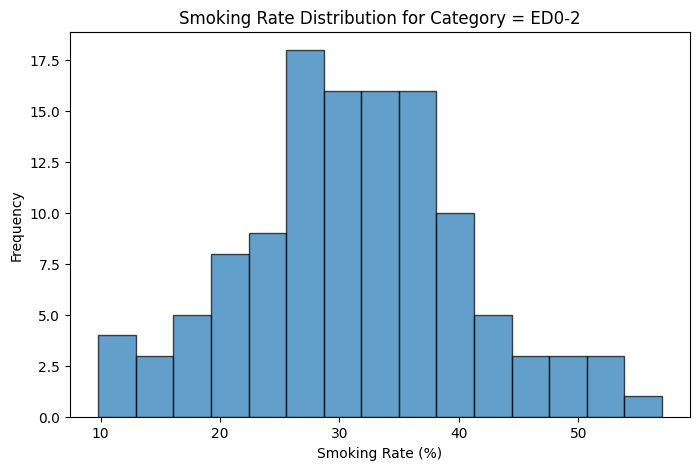

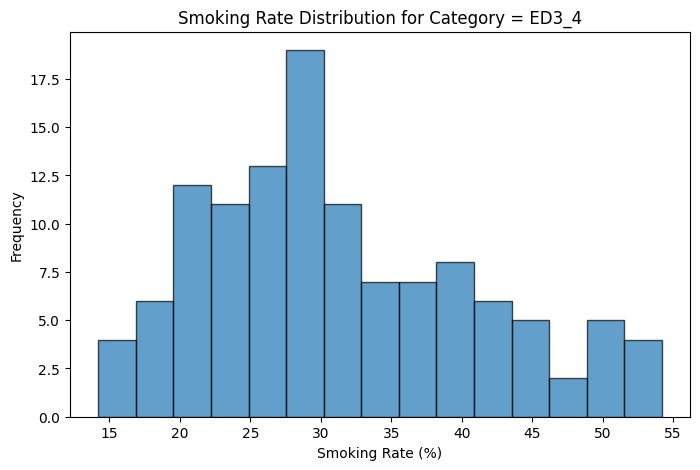

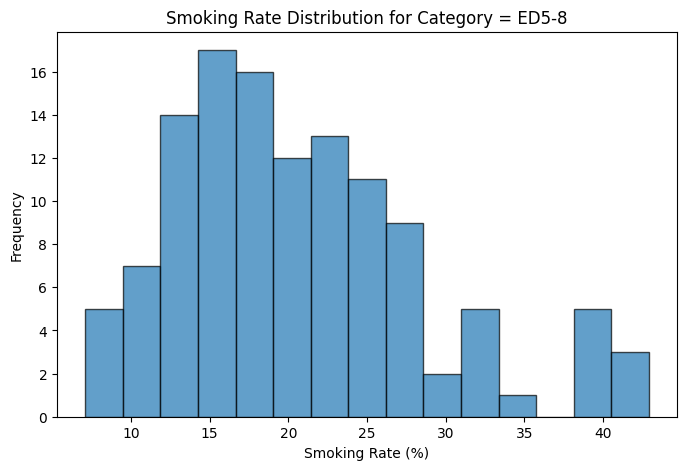

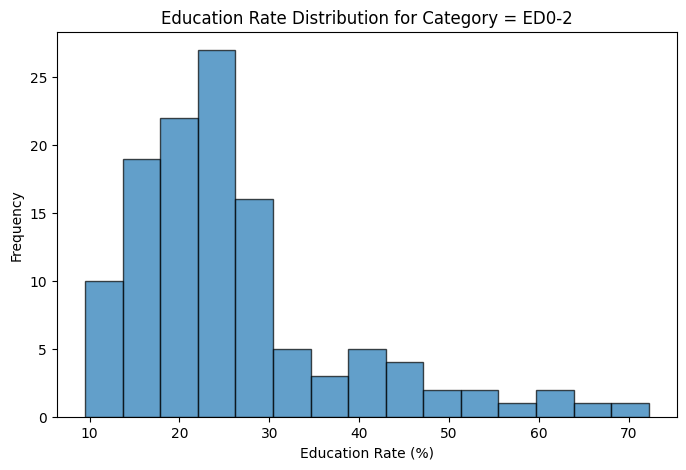

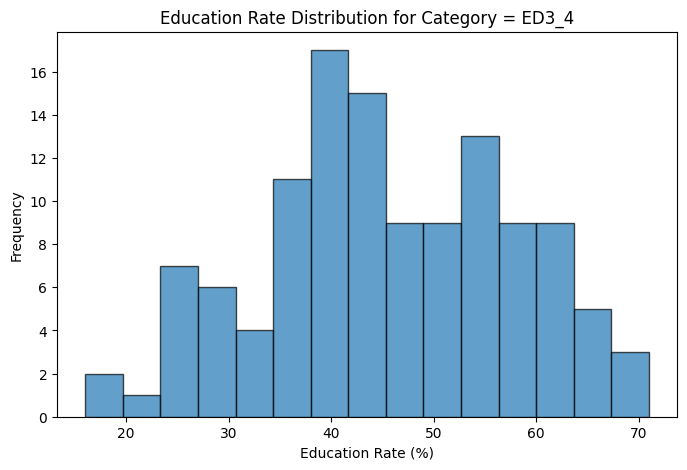

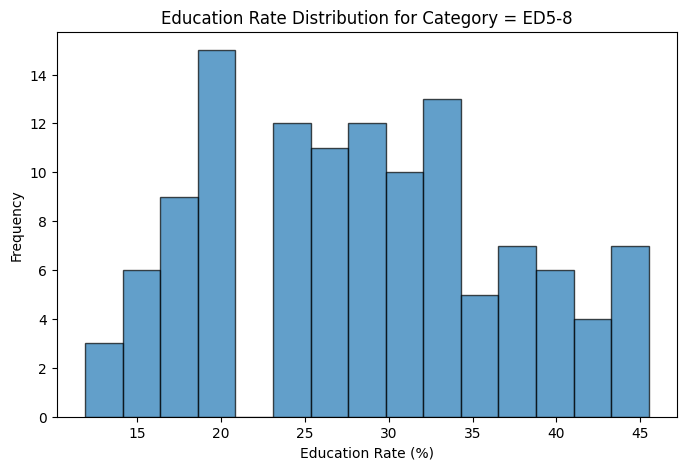

In [276]:
# histogramy rozlozenia dat v "smoking_rate" pre rôzne kategórie vzdelania "isced11"
for category in data_merged["isced11"].unique():
    subset = data_merged[data_merged["isced11"] == category]
    plt.figure(figsize=(8, 5))
    plt.hist(subset["smoking_rate"], bins=15, edgecolor='black', alpha=0.7)
    plt.title(f"Smoking Rate Distribution for Category = {category}")
    plt.xlabel("Smoking Rate (%)")
    plt.ylabel("Frequency")
    plt.show()

# histogramy rozlozenia dat v "education_rate" pre rôzne kategórie vzdelania "isced11"
for category in data_merged["isced11"].unique():
    subset = data_merged[data_merged["isced11"] == category]
    plt.figure(figsize=(8, 5))
    plt.hist(subset["education_rate"], bins=15, edgecolor='black', alpha=0.7)
    plt.title(f"Education Rate Distribution for Category = {category}")
    plt.xlabel("Education Rate (%)")
    plt.ylabel("Frequency")
    plt.show()

In [278]:
# testy normalnosti rozlozenia dat (ak je p> 0.5 ta je to norm. rozlozenie)
for category in data_merged["isced11"].unique():
    subset = data_merged[data_merged["isced11"] == category]
    stat, p = shapiro(data_merged["smoking_rate"])
    print(f"Smoking: Shapiro-Wilk Test: Statistics={stat}, P-value={p}, Category: {category}")
for category in data_merged["isced11"].unique():
    subset = data_merged[data_merged["isced11"] == category]
    stat, p = shapiro(data_merged["education_rate"])
    print(f"Education: Shapiro-Wilk Test: Statistics={stat}, P-value={p}, Category: {category}")

Smoking: Shapiro-Wilk Test: Statistics=0.980429464764628, P-value=8.33917459231654e-05, Category: ED0-2
Smoking: Shapiro-Wilk Test: Statistics=0.980429464764628, P-value=8.33917459231654e-05, Category: ED3_4
Smoking: Shapiro-Wilk Test: Statistics=0.980429464764628, P-value=8.33917459231654e-05, Category: ED5-8
Education: Shapiro-Wilk Test: Statistics=0.9541192675069352, P-value=3.689825505093767e-09, Category: ED0-2
Education: Shapiro-Wilk Test: Statistics=0.9541192675069352, P-value=3.689825505093767e-09, Category: ED3_4
Education: Shapiro-Wilk Test: Statistics=0.9541192675069352, P-value=3.689825505093767e-09, Category: ED5-8


In [ ]:
# testy korelacii medzi fajcenim a vzdelanim, v roznych kategoriach vzdelania
for category in data_merged['isced11'].unique():
    relevant_data = data_merged[data_merged['isced11'] == category]
    corr, p = spearmanr(relevant_data["education_rate"], relevant_data["smoking_rate"])
    print(f"Spearman Correlation: {corr}, P-value: {p} Subset: {category}")
for category in data_merged['isced11'].unique():
    relevant_data = data_merged[data_merged['isced11'] == category]
    corr, p = pearsonr(relevant_data["education_rate"], relevant_data["smoking_rate"])
    print(f"Pearson Correlation: {corr}, P-value: {p} Subset: {category}")


Spearman Correlation: -0.09147738026827894, P-value: 0.3203781742303986 Subset: ED0-2
Spearman Correlation: 0.4859327711315288, P-value: 1.8433591811707895e-08 Subset: ED3_4
Spearman Correlation: -0.5099377307591063, P-value: 2.6990517765109408e-09 Subset: ED5-8
Pearson Correlation: -0.04949888701095183, P-value: 0.591345734223975 Subset: ED0-2
Pearson Correlation: 0.43599608415463087, P-value: 6.442007964404121e-07 Subset: ED3_4
Pearson Correlation: -0.4857791676125783, P-value: 1.865283797237085e-08 Subset: ED5-8


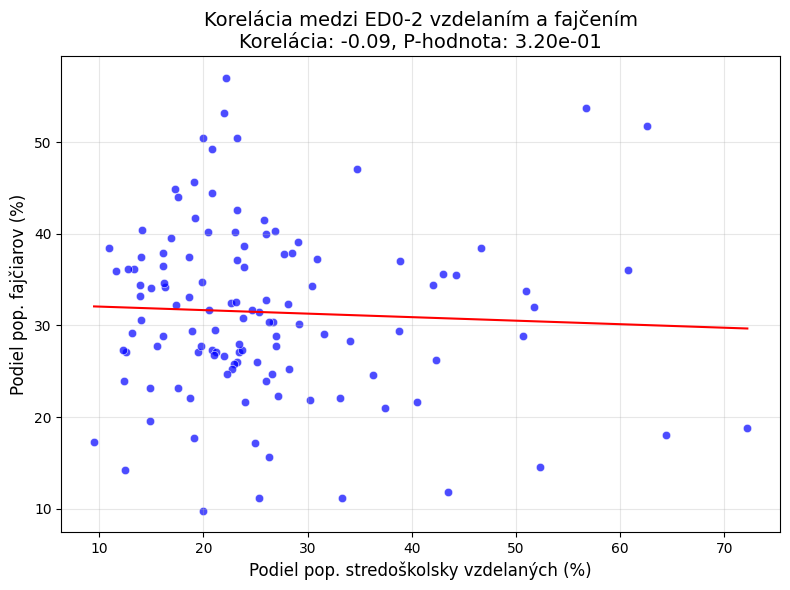

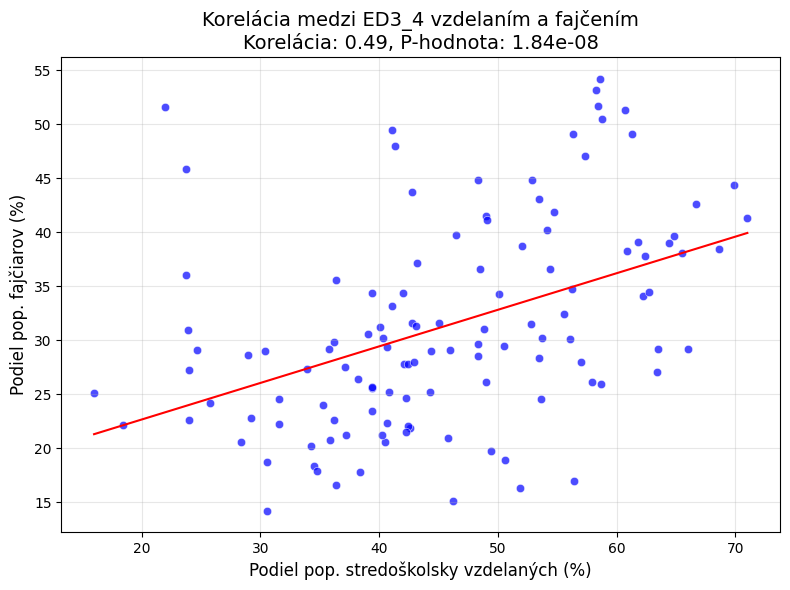

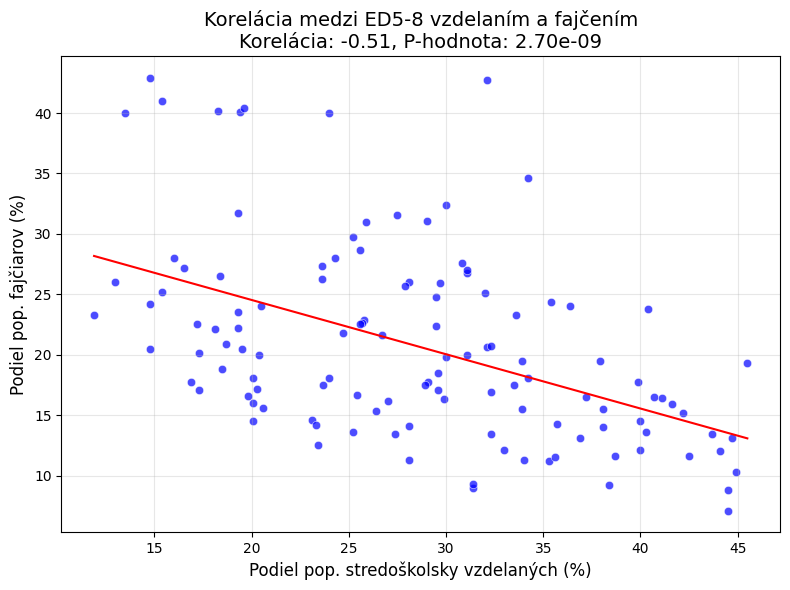

In [ ]:
# scatter plot pre korelacie
for category in data_merged['isced11'].unique():
    relevant_data = data_merged[data_merged['isced11'] == category]

    plt.figure(figsize=(8, 6))  # velkost grafu
    sns.scatterplot(
        x=relevant_data["education_rate"], 
        y=relevant_data["smoking_rate"], 
        alpha=0.7, 
        color="blue"
    )

    # pridanie korelacnej/regresnej ciary
    sns.regplot(
        x=relevant_data["education_rate"], 
        y=relevant_data["smoking_rate"], 
        scatter=False, 
        color="red", 
        ci=None, 
        line_kws={"linewidth": 1.5, "label": "Regresná čiara"}
    )

    # vypocet statistik, aby sa mohli premietnut do grafu
    corr, p = spearmanr(relevant_data["education_rate"], relevant_data["smoking_rate"])

    # popisky grafu
    plt.title(f"Korelácia medzi {category} vzdelaním a fajčením\nKorelácia: {corr:.2f}, P-hodnota: {p:.2e}", fontsize=14)
    plt.xlabel("Podiel pop. takto vzdelaných (%)", fontsize=12)
    plt.ylabel("Podiel pop. fajčiarov (%)", fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()

    plt.show()